<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm

In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import timm

In [68]:

def read_data(directory, shift=0, termi=10):
    """
    Traverse directories starting from 'directory', find .nil files,
    and read them into NumPy arrays.
    """
    data_dict = {}
    k = 0
    ncut = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii'):
                if (k<shift)       :
                  k += 1
                  continue
                file_path = os.path.join(root, file)
                nii_file =  nib.load(file_path)
                data = nii_file.get_fdata()
                data_dict[file.strip('.nii')] = data
                ncut +=  1
                if ncut == termi:
                  return data_dict
    return data_dict

def read_label(excel_path):
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    return df

def get_confusion(guess, truth):

  right = guess == truth
  wrong = torch.logical_not(right)
  TP = torch.sum(torch.logical_and(right, truth == torch.ones(right.shape)))
  TN = torch.sum(torch.logical_and(right, truth == torch.zeros(right.shape)))
  FN = torch.sum(torch.logical_and(wrong, truth == torch.ones(wrong.shape)))
  FP = torch.sum(torch.logical_and(wrong, truth == torch.zeros(wrong.shape)))
  cofu = torch.tensor([[TP, FP], [FN, TN]])
  return (TP,FP,FN,TN)


def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面

def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        raise("GPU not available")
    return device

In [4]:
device = isgpu()

GPU is available


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 路徑


In [6]:
cd /content/drive/MyDrive/AOCR2024

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


In [7]:
!pwd

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


# 處理資料

In [8]:
data = read_data("TrainValid_Image/train_data")
df = read_label("TrainValid_ground_truth.csv")
df.set_index('id', inplace=True)
# df
processed = []
for key, value in data.items():
  scan  = df.loc[df.index.str.startswith(key+'_')]
  labels = np.array(scan['label'])
  processed.append((value, labels))
len(processed)

10

In [9]:
len(data.keys())

10

In [10]:
# 把每個scan第三個維度的資訊取出來,訓練完好分辨哪個cut屬於哪個scan(訓練不改變cut的順序)
nslices = [datatuple[0].shape[2] for datatuple in processed]
keys = list(data.keys())
assert(len(keys) == len(nslices))

In [11]:

# 轉換每個掃描中的圖像和標籤
images_list = []
labels_list = []

for value, label in processed:
    # value.shape 為 (512, 512, n)，label.shape 為 (n,)
    for i in range(value.shape[2]):
        image = value[:, :, i]
        image_tensor = torch.from_numpy(image).float().unsqueeze(0)  # 添加通道維度
        label_tensor = torch.tensor(label[i], dtype=torch.float32)
        images_list.append(image_tensor)
        labels_list.append(label_tensor)

# 合併成批次數據
images = torch.stack(images_list)
labels = torch.stack(labels_list)


# 訓練 (Unet with only encoder)

In [12]:
class FC(nn.Module):
    def __init__(self, in_channels):
        super(FC, self).__init__()

        # Encoder部分
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(128 * 128 * 256, 1)  # x 和 y 是經過 encoder 處理後的特徵圖尺寸


    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

## 訓練 (EfficiencyNetV2_m)

In [105]:
model_name = "tf_efficientnetv2_m"
pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 2
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)

# 檢查模型結構
# print(pretrained_model)

model.safetensors:   0%|          | 0.00/218M [00:00<?, ?B/s]

In [13]:
num_epochs = 3
batch_size = 16
lr = 0.001
num_batches = len(images) // batch_size  #最後data不滿一個batch丟棄
# 初始化模型、損失函數和優化器
model = FC(in_channels=1).to(device)
# model = pretrained_model


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

running_loss_list = []

# 訓練循環
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i in range(num_batches):
        batch_images = images[i*batch_size:(i+1)*batch_size].to(device)
        batch_labels = labels[i*batch_size:(i+1)*batch_size].to(device)

        optimizer.zero_grad()
        outputs = model(batch_images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss_list.append(running_loss/num_batches)
    print(f"Epoch {epoch+1}, Loss: {running_loss/num_batches}")


Epoch 1, Loss: 4.5815788269042965
Epoch 2, Loss: 4.375
Epoch 3, Loss: 4.375


# Loss圖

Text(0, 0.5, 'Loss')

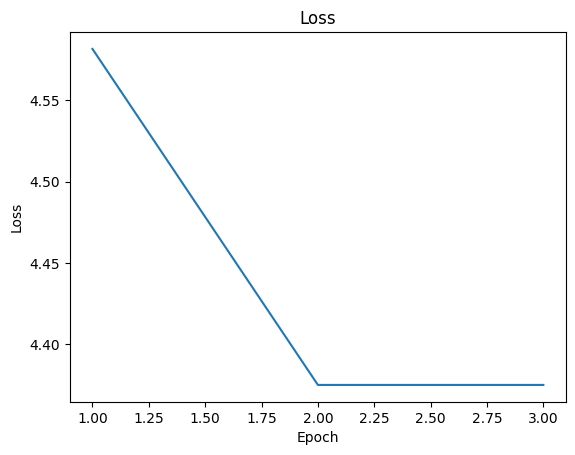

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,num_epochs+1), running_loss_list)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 儲存模型參數



In [16]:
cd /content/drive/MyDrive/AOCR2024

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


In [17]:
import json
appendix = input("請輸入要儲存的編號:")
modelname = model.__class__.__name__
filename = f"params/{modelname}/{modelname}{appendix}"
if os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth exist.")
else:
    torch.save(model.state_dict(), f'{filename}.pth')

params = {
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': lr
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

請輸入要儲存的編號:3


# 讀取模型參數

In [24]:
import json
remove_digits = str.maketrans('', '', '0123456789')
modelname = input("請輸入要獲取模型檔名:")
filename = f"params/{modelname.translate(remove_digits)}/{modelname}"

if 'model' not in globals() or model.__class__.__name__ != modelname.translate(remove_digits):
  exec(f'model = {modelname.translate(remove_digits)}(in_channels=1).to(device)')

if not os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth not exist.")
else:
    print(model.load_state_dict(torch.load(filename+'.pth')))
with open(f'{filename}.json', 'r') as f:
    params = json.load(f)

請輸入要獲取模型檔名:FC3
<All keys matched successfully>


# 評估


In [25]:

# 評估設置
num_epochs = params['num_epochs']
batch_size = params['batch_size']
num_batches = len(images) // batch_size  #最後data不滿一個batch丟棄

In [63]:
model.eval()



predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    correct = 0
    total = 0
    for i in range(num_batches):
        batch_images = images[i*batch_size:(i+1)*batch_size].to(device)
        batch_labels = labels[i*batch_size:(i+1)*batch_size].to(device)

        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()



In [64]:
TP,FP,FN,TN = get_confusion(predict_listq, labels[:len(predict_list)])
print(f"\n\
     真實值\n\
預  +-----+-----+\n\
測| TP: {TP}| FP: {FP}|\n\
值| FN: {FN}| TN: {TN}|\n\
    +-----+-----+ \n\
 \n")

recall = TP/(TP + FN)
precision = TP/(TP + FP)
recall = 0 if torch.isnan(recall) else recall.item()
precision = 0 if torch.isnan(precision) else precision.item()
F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

print(f"{recall=}\n{precision=}\n{F1=}\n")


     真實值
預  +-----+-----+
測| TP: 0| FP: 0|
值| FN: 42| TN: 918|
    +-----+-----+ 
 

recall=0.0
precision=0
F1=0



# 輸出至submission.csv

In [69]:
predict_list = predict_listq.numpy()
## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
key_th = 0  #第幾個scan的key
ii = 0   #每個key輪到第幾個
nslice = nslices[key_th]  #對應scan的cut數
for i in range(len(predict_list)):
  if (ii >= nslice):
    output[keys[key_th]] = int(predict_list[i-nslice:i].any())
    key_th += 1
    ii = 0
    nslice = nslices[key_th]
  label = predict_list[i]
  output[keys[key_th]+f'_{ii}'] = predict_list[i]
  ii += 1
output[keys[key_th]] = int(predict_list[i-ii:].any()) #補上最後一個scan判斷

output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key))
dfout.to_csv('submission.csv', index=False)

In [71]:
dfout

,id,label
595,Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF...,0.0
505,Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF...,0.0
506,Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF...,0.0
507,Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF...,0.0
508,Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF...,0.0
...,...,...
197,Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06...,0.0
198,Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06...,0.0
199,Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06...,0.0
200,Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06...,0.0
